## Employee Attrition: Will my employee leave?

### How can we identify employees at-risk for voluntary resignation based on their performance, job satisfaction, supervisor's behaviours etc.?
**Context**:

It's estimated that losing an employee can cost a company 1.5-2x the employee’s salary. Depending on the individual’s level of seniority, the financial burden fluctuates. For hourly workers, it costs an average of $1,500 per employee. For technical positions, the cost jumps to 100-150% of salary. At the high end, C-suite turnover can cost up to 213% of the employee’s salary.

Not only are you forced to dedicate time and resources to recruiting, onboarding and training a new hire after an employee leaves, but it’s estimated that two thirds of all sunk costs due to turnover are intangible, including lost productivity and knowledge, and internal strain on employees while the roles remain unfilled. 

Being able to predict, and possibly minimize, employee turnover by identifying employees that may be at-risk for leaving voluntarily could help to reduce the cost of replacement hire due to turnover and increase employee retention.

Specifically, the question I'm seeking to answer is, "**What contributing factors increase the likelihood of an employee leaving voluntarily?**", and can we use those to determine when, and if, an employee might resign?

### Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import json
sns.set_style('whitegrid')

### **Dataset**

In [2]:
# Dataset 
workers = pd.read_csv("../data/raw/factory_workers.csv", sep=',', encoding="mac_roman")

### Understanding the Dataset 
This synthetic dataset contains 18 months’ worth of daily performance and attrition data (411,948 observations) for a factory whose organizational structure comprises 508 workers. Due to employee turnover, a total of 687 persons appear in the dataset. The dataset’s observations cover both regular daily events (like workers’ attendance and daily level of Efficacy) and special one-time events (like accidents, an employee’s termination, or the onboarding of a new employee). A unique feature of the dataset is diverse causal relationships “hidden” within the data that are waiting to be uncovered through machine learning.

Each record represents a type of **event that occurred on a particular day in relation to a particular worker**. It’s possible for a given worker to have more than one event (and row) for the same day. There are 14 kinds of events:

- Presence: worker showed up to work

- Absence: worker did not show up to work

- Efficacy: reflects the degree of efficiency and productivity that an employee demonstrated over the course of the given workday. There are two related elements: the actual Efficacy that the employee generated on the given day, and the recorded Efficacy that the worker’s supervisor entered into the factory’s HRM/ERP system for the employee for that day. 

- Resignation: on the given date, an employee quit his or her job (i.e., the employee experienced a voluntary separation). After resigning, the employee was no longer a part of the workforce and did not generate any future behaviors. Only Laborers and Team Leaders are liable to experience a Resignation event

- Termination: the employee was fired by the organization (i.e., the employee experienced an involuntary separation).

- Onboarding: subject is a newly hired employee who began work on the given date. In order to maintain a stable size for the factory’s workforce, a new employee is hired whenever an existing employee has resigned or been terminated.

- Idea: when an employee imagines some innovative new approach to solving a long-standing problem or otherwise improving the factory’s functioning. Workers with a high Perceptiveness stat are more likely to have an Idea.

- Lapse: when a worker makes some severe mental mistake that negatively impacts the factory’s functioning (e.g., by omitting some step from a business process or ordering the wrong parts). Workers with a low Perceptiveness stat are more likely to have a lapse.

- Feat: when an employee performs some exceptional act dependent on physical skill (e.g., expertly manipulating some high-precision tool or sorting objects into bins with remarkable speed). Workers with a high Dexterity stat are more likely to generate a Feat.

- Slip: when an employee experiences some accident or misstep resulting from a lack of physical adroitness (e.g., knocking over a storage rack or dropping some delicate instrument). Workers with a low Dexterity stat are more likely to generate a Slip behavior.

- Teamwork: when an employee goes to exceptional lengths to encourage, teach, or otherwise support his or her colleagues in some way. Workers with a high Sociality stat are more likely to generate this event

- Disruption: occurs when an employee quarrels with colleagues, belligerently rejects a supervisor’s request, or otherwise displays a hostile attitude toward his or her coworkers. Workers with a low Sociality stat are more likely to generate this event. 

- Sacrifice: when a worker performs – of his or her own initiative – some action that’s unpleasant or inconvenient for the employee but which spares others from suffering the same hardship (e.g., volunteering to take on some grueling or unpleasant assignment that no one else wants to do). Workers with a high Goodness stat are more likely to generate a Sacrifice behavior.

- Sabotage: when an employee knowingly performs some act (typically, with the hope that he or she won’t be observed while doing so) that will damage equipment, spoil products, or otherwise lessen the organization’s productivity or harm its brand image. Workers with a low Goodness stat are more likely to generate a Sabotage behavior

In [3]:
workers.head(5)

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
0,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
1,98000001,Rebecca,Bauer,40,F,Shift 1,Team 1,Team Leader,"[98000002, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Efficacy,None,1.489,Efficacy,None,1.2,None,None
2,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None
3,98000002,Joan,Winter,61,F,Shift 1,Team 2,Team Leader,"[98000001, 98000003, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Efficacy,None,1.023,Efficacy,None,0.8,None,None
4,98000003,Elizabeth,Martinez,20,F,Shift 1,Team 3,Team Leader,"[98000001, 98000002, 98000004, 98000005, 98000...",0.714285714,...,4,Friday,Presence,None,None,Presence,None,None,None,None


In [4]:
workers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411948 entries, 0 to 411947
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   sub_ID                   411948 non-null  int64  
 1   sub_fname                411948 non-null  object 
 2   sub_lname                411948 non-null  object 
 3   sub_age                  411948 non-null  int64  
 4   sub_sex                  411948 non-null  object 
 5   sub_shift                411948 non-null  object 
 6   sub_team                 411948 non-null  object 
 7   sub_role                 411948 non-null  object 
 8   sub_coll_IDs             411948 non-null  object 
 9   sub_colls_same_sex_prtn  411948 non-null  object 
 10  sub_health_h             411948 non-null  float64
 11  sub_commitment_h         411948 non-null  float64
 12  sub_perceptiveness_h     411948 non-null  float64
 13  sub_dexterity_h          411948 non-null  float64
 14  sub_

The dataframe consists of 42 features, all with data types of either float, integer or object.

### Helpful tool: Lookup function
Since there are 42 columns in this dataset, each with its own description, use this lookup function to quickly take a look at what the column heading may mean.

In [19]:
# Get Column description function
with open("../data/raw/metadata.json") as file:
    column_descriptions = json.load(file)

# Define a lookup function for getting the description of a column name
def get_column_desc(col_name, info=column_descriptions):
    """
    Provides a lookup function for a description of the inputted list of column names. 
    
    This function takes a list of column names as a list and returns a dictionary of column names \ 
    and corresponding descriptions.
    
    Parameters:
    col_name(list): List of column names you wish to lookup.
    info(dict): A JSON file containing metadata.
    
    Returns: 
    dict: Returns column name and its description.
    
    """
    desc = dict()
    for name in col_name:
        desc[name] = info[name]["Description"]
    return desc


### Getting an idea of the distribution of 'Events' (Idea, Feat, Resignation, etc.)

There are two columns pertaining to an 'event': **`behav_comptype_h`**, which is hidden, and **`record_comptype`**. One is the actual underlying event performed by the worker, and the latter is the recorded event inputted by the supervisor. We will use the lookup function to get a better idea of the columns.

In [6]:
# Get a description of the Column headings related to events
get_column_desc(['behav_comptype_h', 'record_comptype'])

{'behav_comptype_h': 'A string describing the underlying kind of behavior that the event’s subject actually performed on the given day and which is reflected in the row’s event. Possible values are “Presence”, “Absence”, “Resignation”, “Onboarding”, “Efficacy”, “Idea”, “Lapse”, “Feat”, “Slip”, “Teamwork”, “Disruption”, “Sacrifice”, and “Sabotage”. The value will be “None” in the case of a “Termination” event (which is solely an action on the part of the supervisor, not the subordinate; it includes a record component reflecting the HRM/ERP system entry made by the supervisor but no behavior component on the part of the subordinate).',
 'record_comptype': 'A string describing the type of record made by the subject’s supervisor in the factory’s HRM/ERP system, in connection with the underlying behavior performed by the worker; it’s the record component of the event. Possible values are “Presence”, “Absence”, “Resignation”, “Termination”, “Onboarding”, “Efficacy”, “Idea”, “Lapse”, “Feat”, 

**Let's compare the two columns** 

In [20]:
# Removed records where behav_comptype_h is 'None' because that meant a termination event
df_without_term_event = workers[(workers['behav_comptype_h'] != 'None')]
recorded_event = df_without_term_event.groupby('record_comptype')['record_comptype'].count()
actual_event = df_without_term_event.groupby('behav_comptype_h')['behav_comptype_h'].count()
diff = recorded_event - actual_event

# DF comparing actual vs recorded events 
events = pd.concat([recorded_event, actual_event, diff], axis=1)
events.columns=['Recorded by Supervisor', 'Actual Event', 'Difference']
events

,Recorded by Supervisor,Actual Event,Difference
Absence,6519,6524.0,-5.0
Disruption,781,927.0,-146.0
Efficacy,191272,191657.0,-385.0
Feat,3387,3937.0,-550.0
Idea,3334,3899.0,-565.0
Lapse,1344,1587.0,-243.0
None,3938,NaN,NaN
Onboarding,179,179.0,0.0
Presence,191272,191657.0,-385.0
Resignation,77,77.0,0.0


Comparing the two, right away we can see that there is a mismatch between what was **actually done vs. what was actually recorded by the supervisor**. For example, there were 550 mismatched records for employee 'Feats', 565 for 'Ideas' and 751 for 'Sacrifices', just to highlight a few.

Consistently overperforming and not being recognized can lead to some potential frustration by the employee and is an interesting point to investigate. 

Let's probe a little bit further.

In [8]:
# DataFrame showing mismatched events between Actual Event performed vs. what the supervisor recorded
mismatched_events = df_without_term_event[df_without_term_event['record_comptype'] != df_without_term_event['behav_comptype_h']][['behav_comptype_h', 'record_comptype']]
mismatched_events.rename(columns={'behav_comptype_h':'Actual Event', 'record_comptype':'Recorded by Supervisor'}, inplace=True)
mismatched_events

,Actual Event,Recorded by Supervisor
359,Idea,None
382,Feat,None
428,Sacrifice,None
431,Presence,None
432,Efficacy,None
...,...,...
411708,Teamwork,None
411713,Lapse,None
411813,Teamwork,None
411932,Teamwork,None


Comparing the two columns separately, we can see that there are about **3938 records** of mismatched events where the supervisor recorded something different than was performed for that given record. In a lot of cases, we can see tha a supervisor just simply did not record a **positive** event like Sacrifice or Feat. That is a lot of mismatch!

In [9]:
"""
# Visualize a count of the different events excluding Presence and Efficacy for Actual Event
workers_no_pres_or_eff = workers[(workers['record_comptype'] != 'Presence') & (workers['record_comptype'] != 'Efficacy')]

g = sns.catplot(x='behav_comptype_h', data=workers_no_pres_or_eff, kind='count')
#Places counts at top of bar
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])
g.fig.suptitle('Count of Event Types')
g.fig.subplots_adjust(top=0.9)
plt.xticks(rotation=90)
plt.show()
"""

"\n# Visualize a count of the different events excluding Presence and Efficacy for Actual Event\nworkers_no_pres_or_eff = workers[(workers['record_comptype'] != 'Presence') & (workers['record_comptype'] != 'Efficacy')]\n\ng = sns.catplot(x='behav_comptype_h', data=workers_no_pres_or_eff, kind='count')\n#Places counts at top of bar\nfor ax in g.axes.flat:\n    ax.bar_label(ax.containers[0])\ng.fig.suptitle('Count of Event Types')\ng.fig.subplots_adjust(top=0.9)\nplt.xticks(rotation=90)\nplt.show()\n"

In [10]:
"""
Visualize a count of the different events excluding Presence and Efficacy for Recorded Event by Sup
workers_no_pres_or_eff = workers[(workers['record_comptype'] != 'Presence') & (workers['record_comptype'] != 'Efficacy')]

g = sns.catplot(x='record_comptype', data=workers_no_pres_or_eff, kind='count')
#Places counts at top of bar
for ax in g.axes.flat:
    ax.bar_label(ax.containers[0])
g.fig.suptitle('Count of Event Types')
g.fig.subplots_adjust(top=0.9)
plt.xticks(rotation=90)
plt.show()
"""

"\nVisualize a count of the different events excluding Presence and Efficacy for Recorded Event by Sup\nworkers_no_pres_or_eff = workers[(workers['record_comptype'] != 'Presence') & (workers['record_comptype'] != 'Efficacy')]\n\ng = sns.catplot(x='record_comptype', data=workers_no_pres_or_eff, kind='count')\n#Places counts at top of bar\nfor ax in g.axes.flat:\n    ax.bar_label(ax.containers[0])\ng.fig.suptitle('Count of Event Types')\ng.fig.subplots_adjust(top=0.9)\nplt.xticks(rotation=90)\nplt.show()\n"

## **Graphical Exploratory Data Analysis**

Going into this exploratory analysis with the problem I'm trying to solve in mind, my initial thought is that my response variable will most likely be the records that have a **'Resignation'** event listed. Those records that involved a 'Termination' event are outside the scope of the question I'm trying to answer.

Since I'm trying to predict what factors will contribute to an employee leaving (voluntarily), there will be several explanatory variables. My instinct is to divide and investigate them in three iterations: **explanatory variables related to the employee's role, performance, attitudes, etc.; explanatory variables related to the supervisor's; and a combination of the two.**



### Firstly, how many employees resigned?

In [11]:
# Subset original dataframe for turnover events (Resignation and Termination)
turnover = ['Resignation', 'Termination']
turnover_events = workers[workers['record_comptype'].isin(turnover)]
turnover_events

,sub_ID,sub_fname,sub_lname,sub_age,sub_sex,sub_shift,sub_team,sub_role,sub_coll_IDs,sub_colls_same_sex_prtn,...,event_weekday_num,event_weekday_name,behav_comptype_h,behav_cause_h,actual_efficacy_h,record_comptype,record_cause,recorded_efficacy,recorded_note_from_sup,record_conf_matrix_h
1056,98000112,Dorothy,Reynolds,61,F,Shift 1,Team 5,Laborer,"[98000106, 98000109, 98000110, 98000111, 98000...",0.526315789,...,4,Friday,Resignation,Poor Teammates,None,Resignation,None,None,NaN,None
1057,98000462,Mark,Bauer,63,M,Shift 3,Team 22,Laborer,"[98000449, 98000450, 98000451, 98000452, 98000...",0.368421053,...,4,Friday,Resignation,Underrecorded Efficacy,None,Resignation,None,None,NaN,None
1058,98000598,Francis,Weber,19,M,Shift 1,Team 5,Laborer,"[98000106, 98000109, 98000110, 98000111, 98000...",0.421052632,...,4,Friday,None,None,None,Termination,Low Efficacy,None,NaN,None
2116,98000264,Mary,Ortiz,61,F,Shift 2,Team 12,Laborer,"[98000246, 98000247, 98000248, 98000249, 98000...",0.789473684,...,0,Monday,Resignation,Recruited Away,None,Resignation,None,None,NaN,None
5272,98000081,Carol,Wieczorek,49,F,Shift 1,Team 3,Laborer,"[98000066, 98000067, 98000068, 98000069, 98000...",0.473684211,...,3,Thursday,None,None,None,Termination,Multiple Sabotages,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390829,98000778,Dennis,Walker,48,M,Shift 2,Team 12,Laborer,"[98000247, 98000249, 98000250, 98000251, 98000...",0.315789474,...,3,Thursday,None,None,None,Termination,Multiple Absences,None,NaN,None
400307,98000727,Robert,Novak,54,M,Shift 1,Team 8,Laborer,"[98000166, 98000168, 98000170, 98000171, 98000...",0.631578947,...,2,Wednesday,Resignation,Recruited Away,None,Resignation,None,None,NaN,None
400308,98000779,Margaret,Castellano,34,F,Shift 3,Team 21,Laborer,"[98000428, 98000429, 98000430, 98000431, 98000...",0.526315789,...,2,Wednesday,Resignation,Poor Teammates,None,Resignation,None,None,NaN,None
407664,98000139,Benjamin,Rossi,54,M,Shift 1,Team 6,Laborer,"[98000125, 98000127, 98000130, 98000131, 98000...",0.473684211,...,4,Friday,None,None,None,Termination,Multiple Sabotages,None,NaN,None


Over the course of 18 months, this factory had 179 turnover events. 

In [12]:
resignations = turnover_events[turnover_events['record_comptype'] == 'Resignation']

len(resignations)

77

Of the 179 turnover events, 77 employees voluntarily resigned!

# Is there anything in common with those employees that resigned?
What are some explanatory variables related to the employee that might have correlation with a Resignation event?

**Age, Sex, Shift, Team, and Role. Some 'hidden' traits include the employee's health, commitment, perceptiveness, dexterity, sociality, strength, goodness, open-mindedness, and workstyle all seem to be some interesting features.**

**What do these columns mean?**

In [71]:
# Column descriptions related to employee role in factory
work_desc = ['sub_age', 'sub_team', 'sub_sex', 'sub_shift', 'sub_role']
get_column_desc(work_desc)

{'sub_age': 'The age of the event’s subject.',
 'sub_team': 'The name of the team on which the event’s subject works. For an employee working on Shift 1, possible values are “Team 1” through “Team 8” (for persons filling the role of Team Leader or Laborer) or “unassigned” (for the Shift Manager, who isn’t assigned to a single team but instead oversees all of the shift’s teams). Similarly, Shift 2 includes “Team 9” through “Team 16”, and Shift 3 includes “Team 17” through “Team 24”. The factory’s three Shift Managers and one Production Director also have “unassigned” as a value, as they aren’t members of a particular team.',
 'sub_sex': 'The sex (“M” or “F”) of the employee who is the event’s subject.',
 'sub_shift': 'The name of the shift on which the event’s subject works. Possible values are “Shift 1”, “Shift 2”, “Shift 3”, or “unassigned” (for the factory’s lone Production Director, who isn’t assigned to a single shift but instead oversees all of the shifts).',
 'sub_role': 'The org

In [14]:
# Column descriptions related to employee hidden traits
employee_traits_1 = ['sub_health_h', 'sub_commitment_h', 'sub_perceptiveness_h', 'sub_dexterity_h', \
                   'sub_sociality_h', 'sub_goodness_h', 'sub_strength_h', 'sub_health_h', 'sub_openmindedness_h']
get_column_desc(employee_traits_1)

{'sub_health_h': 'A float between 0.0 and 1.0 representing the (hidden) Health stat of the event’s subject.',
 'sub_commitment_h': 'A float between 0.0 and 1.0 representing the (hidden) Commitment stat of the event’s subject.',
 'sub_perceptiveness_h': 'A float between 0.0 and 1.0 representing the (hidden) Perceptiveness stat of the event’s subject.',
 'sub_dexterity_h': 'A float between 0.0 and 1.0 representing the (hidden) Dexterity stat of the event’s subject.',
 'sub_sociality_h': 'A float between 0.0 and 1.0 representing the (hidden) Sociality stat of the event’s subject.',
 'sub_goodness_h': 'A float between 0.0 and 1.0 representing the (hidden) Goodness stat of the event’s subject.',
 'sub_strength_h': 'A float between 0.0 and 1.0 representing the (hidden) Strength stat of the event’s subject.',
 'sub_openmindedness_h': 'A float between 0.0 and 1.0 representing the (hidden) Open-mindedness stat of the event’s subject.'}

Separated the traits for better readability.

In [15]:
employee_traits_2 = ['sub_workstyle_h', 'actual_efficacy_h', 'behav_cause_h', 'behav_comptype_h']
get_column_desc(employee_traits_2)

{'sub_workstyle_h': 'The subject’s “Workstyle group” influences his or her Efficacy (which will be elevated, average, or reduced and either stable or variable); number of Disruptions (either elevated, average, or reduced); and number of Ideas (elevated, average, or reduced). Possible values are “Group A”, “Group B”, “Group C”, “Group D”, and “Group E”. Each Workstyle group has its own characteristic pattern of influences.',
 'actual_efficacy_h': 'In the case of an Efficacy event, this float indicates the actual level of Efficacy that was displayed by the subject on the given day. The minimum value is 0.0; the maximum value is theoretically unlimited. For other event types, this field’s value will be “None”.',
 'behav_cause_h': 'In the case of a Resignation event, this string indicates the subject’s actual (hidden) reason for quitting his or her job. For other event types, the value is “None”.',
 'behav_comptype_h': 'A string describing the underlying kind of behavior that the event’s s

## Employee Traits

Since the value listed in the hidden traits for each employee directly affects the kind of events they may have, I was curious to see whether, of those employees that resigned, did they typically have a value for these hidden traits in a certain range?

Example: a person with a high perceptiveness score is more likely to have an Idea event. 

In [24]:
# Extract traits to compare
worker_traits_1 = ['sub_health_h','sub_commitment_h', 'sub_perceptiveness_h','sub_dexterity_h']
worker_traits_2 = ['sub_sociality_h','sub_goodness_h','sub_strength_h', 'sub_openmindedness_h']
traits = ['sub_health_h','sub_commitment_h', 'sub_perceptiveness_h','sub_dexterity_h', \
         'sub_sociality_h','sub_goodness_h','sub_strength_h', 'sub_openmindedness_h']
num_of_cols = [0,1,2,3]

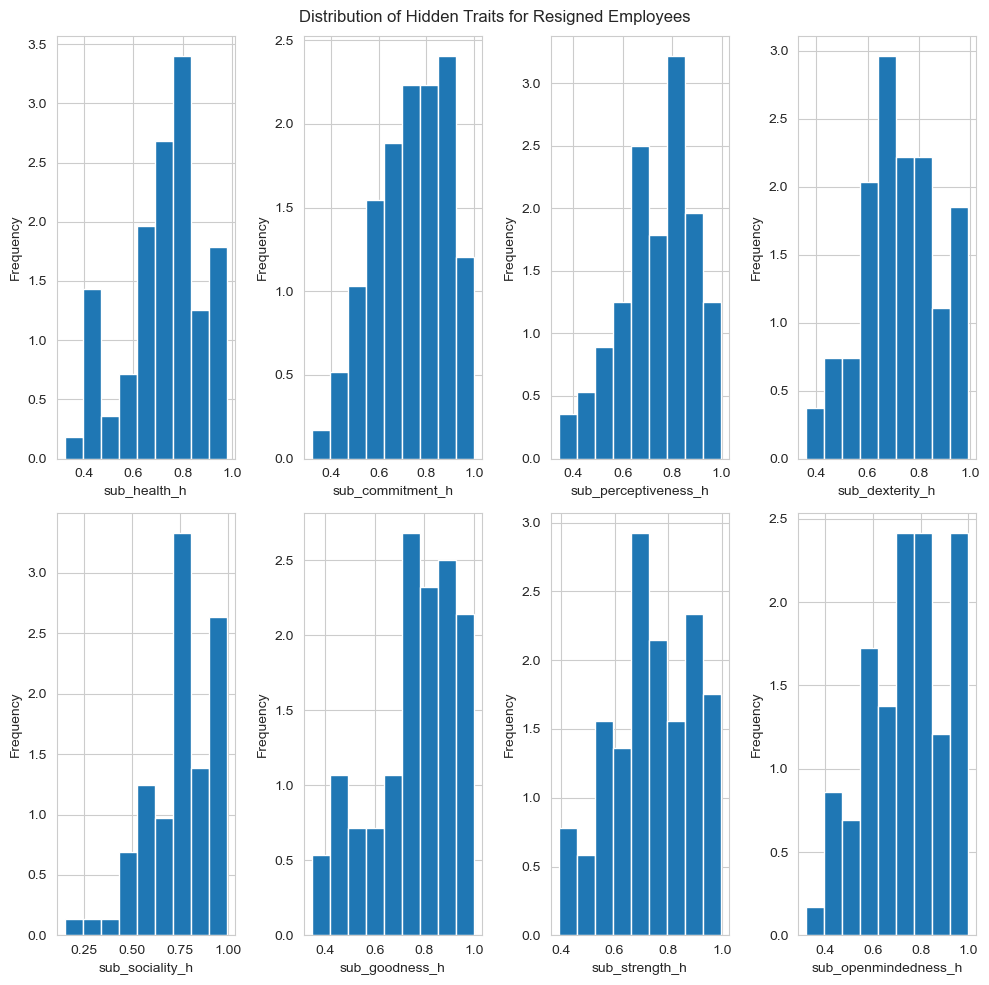

In [82]:
# Plot histograms for each hidden trait

sns.set_style('whitegrid')

fig, ax = plt.subplots(2,4, figsize=(10,10))

for i, feat in zip(num_of_cols, worker_traits_1):
    ax[0,i].hist(x=resignations[feat], bins=9, density=True)
    ax[0,i].set_xlabel(f'{feat}')
    ax[0,i].set_ylabel('Frequency')
    
for i, feat in zip(num_of_cols, worker_traits_2):
    ax[1,i].hist(x=resignations[feat], bins=9, density=True)
    ax[1,i].set_xlabel(f'{feat}')
    ax[1,i].set_ylabel('Frequency')

fig.suptitle('Distribution of Hidden Traits for Resigned Employees')
fig.tight_layout()
plt.show()

From these plots, we can estimate that almost across the board, an employee that resigned typically had values for these traits that ranged between 0.6 - 0.8. 

Perhaps, we can visualize these better in a boxplot. 

/Users/kylerodriguez/miniconda3/envs/employee-attrition/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/kylerodriguez/miniconda3/envs/employee-attrition/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


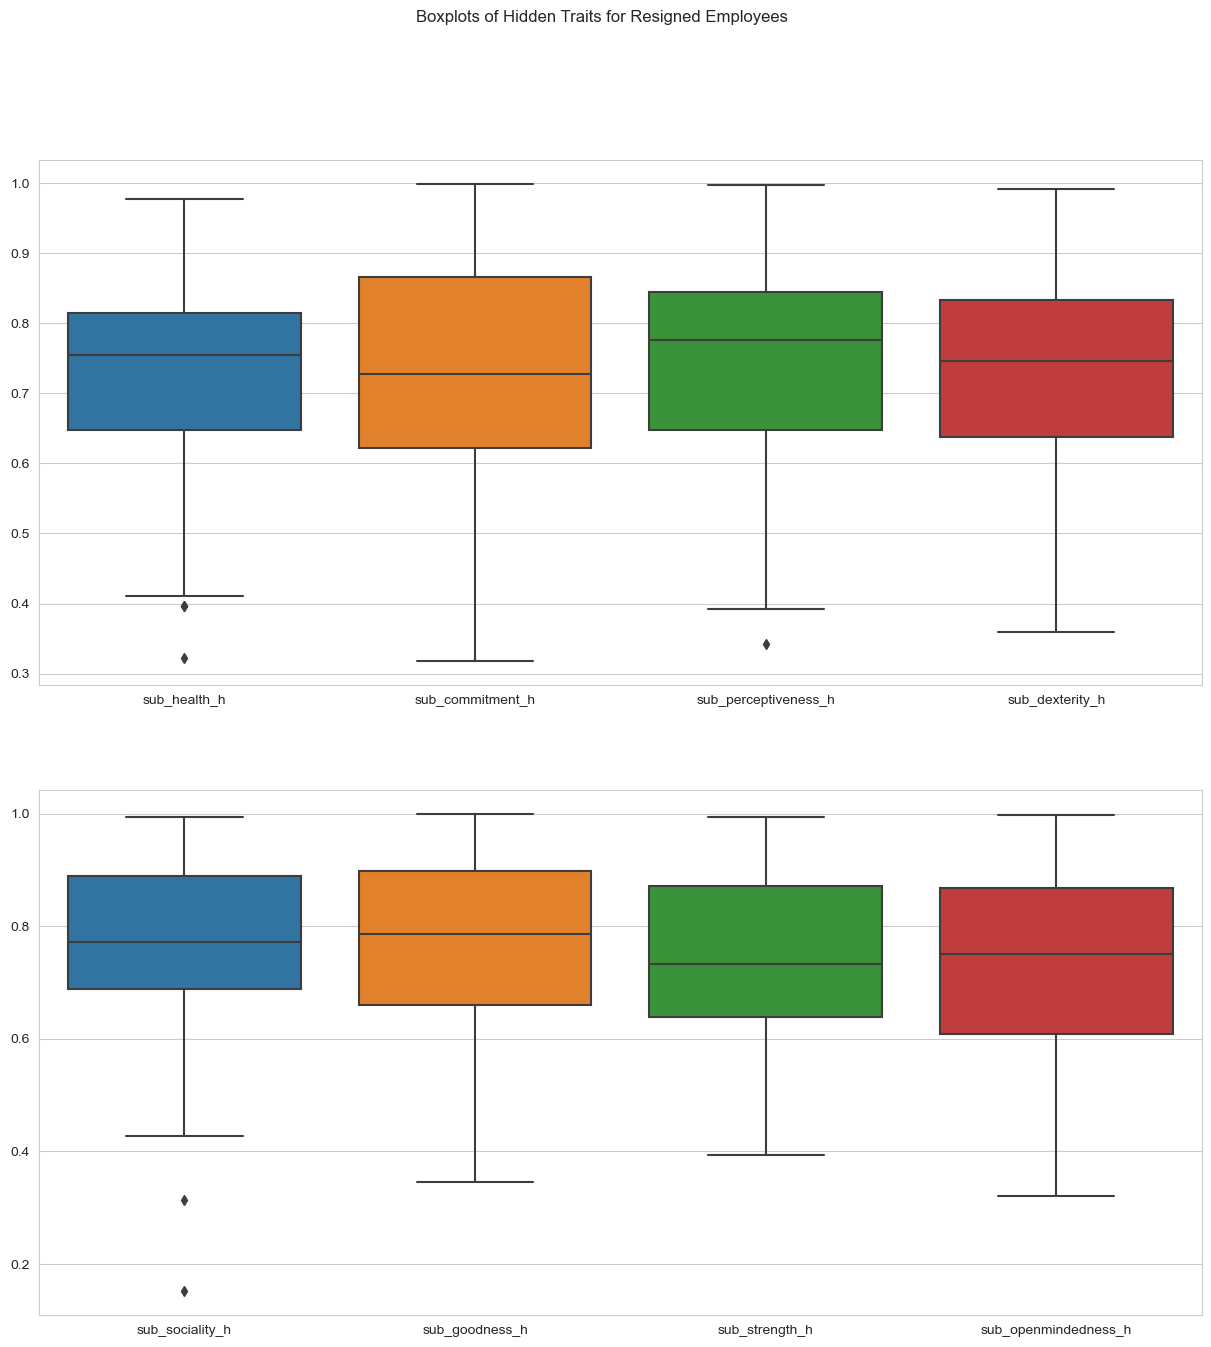

In [78]:
# Boxplots visualizing trait scores of Resigned employees
fig, ax = plt.subplots(2,1,figsize=(15, 15))
sns.boxplot(data=resigned_traits[worker_traits_1], ax=ax[0])
sns.boxplot(data=resigned_traits[worker_traits_2], ax=ax[1])
fig.suptitle('Boxplots of Hidden Traits for Resigned Employees')
plt.show()

Just like we saw in the histograms, the scores in the IQR for these traits all seem to fall between 0.7 - 0.9. Furthermore, the **medians scores seem to hover around 0.75 across the board.**

In [58]:
# Summary statistics for just the traits of resigned employees
resigned_traits = resignations[traits]
resigned_traits.describe()

,sub_health_h,sub_commitment_h,sub_perceptiveness_h,sub_dexterity_h,sub_sociality_h,sub_goodness_h,sub_strength_h,sub_openmindedness_h
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.722584,0.731805,0.739649,0.727987,0.750844,0.756506,0.734701,0.740818
std,0.155644,0.152455,0.147753,0.152054,0.170599,0.169799,0.151227,0.168952
min,0.323000,0.318000,0.342000,0.360000,0.152000,0.346000,0.394000,0.320000
25%,0.648000,0.622000,0.648000,0.638000,0.688000,0.661000,0.639000,0.608000
50%,0.754000,0.728000,0.776000,0.746000,0.772000,0.786000,0.733000,0.750000
75%,0.814000,0.866000,0.844000,0.833000,0.889000,0.898000,0.872000,0.868000
max,0.977000,0.999000,0.997000,0.992000,0.995000,1.000000,0.994000,0.998000


Looking at the actual numbers, we confirmed our interpretations of the graph. The scores all sit in the 0.6 - 0.9 range, and the median scores all hover around 0.75 across the board. 

It's interesting to note that it seems like employees that resigned were neither over- nor under-achievers in terms of these traits.  

## Employees Age, Sex, Shift, Role and Teams

What does the distribution of resigned employees look like across these categories?

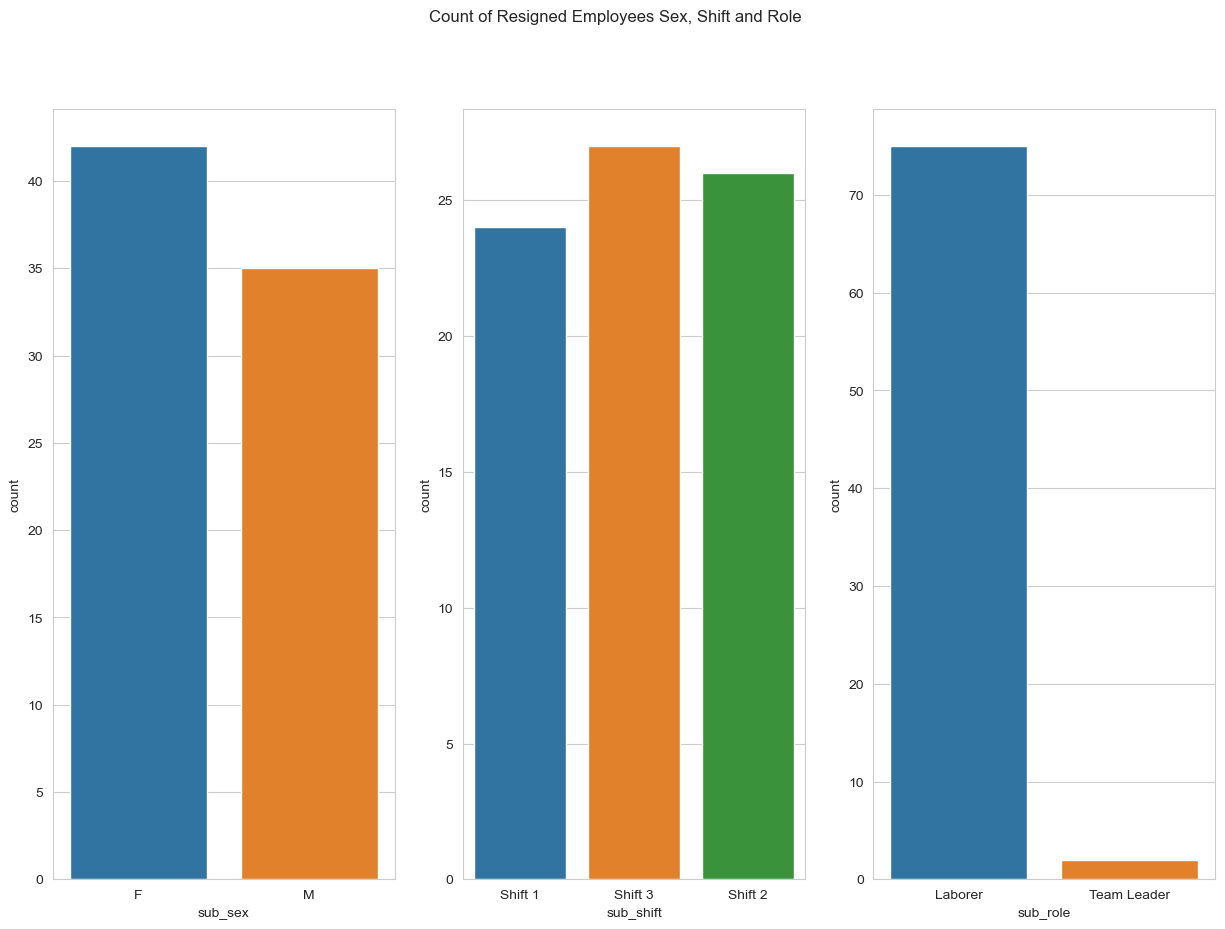

In [77]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
index = 2
for axis in axes:
  sns.countplot(x=resignations[work_desc[index]], ax=axis)
  index = index+1
fig.suptitle('Count of Resigned Employees Sex, Shift and Role')
plt.show()

From the plots above, we can see that there were more Female workers that resigned compared to Male workers. Is this because there is a larger population of female workers in the workforce?

Secondly, though there was slighly more resignations from Shift 3, the number of resignations seem to be average across the shifts.

Lastly, there is a disproportionate amount of Laborers that resigned, as opposed to Team Leaders. 

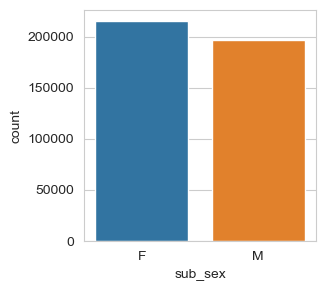

In [125]:
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x=workers['sub_sex'])
plt.show()

There are more female workers in the workforce, so the number of resignations may just be proportional to the workforce makeup.

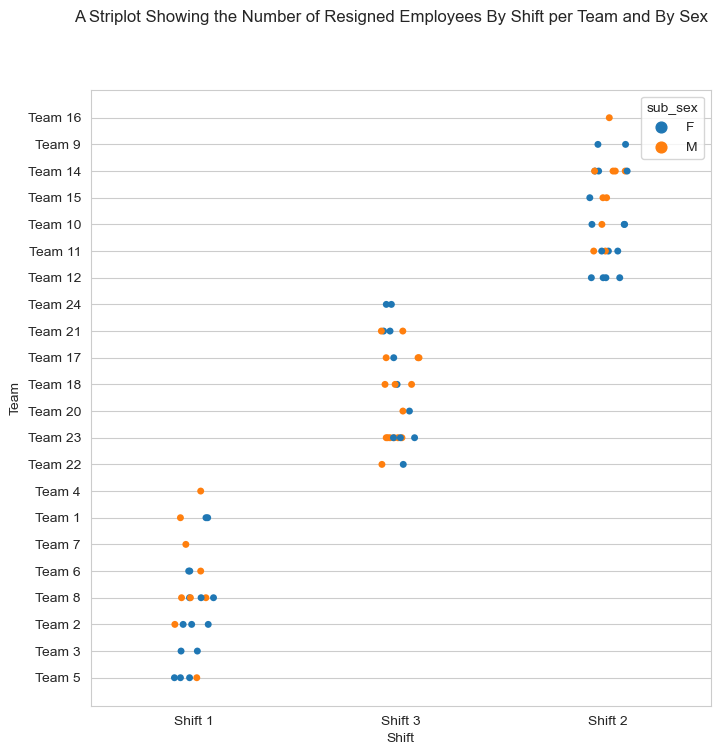

In [152]:
# Visualize the Distribution of Ages for Resigned Employees
fig, ax = plt.subplots(figsize=(8,8))
sns.stripplot(data=resignations, x='sub_shift', y='sub_team', hue='sub_sex')


plt.xlabel('Shift')
plt.ylabel('Team')
fig.suptitle('A Striplot Showing the Number of Resigned Employees By Shift per Team and By Sex')
plt.show()

### Explanatory Variables Related to Supervisor

It's a common saying that employees don't leave their jobs, they leave their managers. In the spirit of this saying, what explanatory variables related to the supervisor might contribute to an employee resigning?

From first glance, some variables include: Age, Age Difference, Sex, Role, Perceptiveness, and Goodness. In addition, variables like recorded comptype, recorded cause, recorded efficacy and recorded note from supervisor seem interesting.

**Understanding the Potential Variables**

In [ ]:
sup_traits = ['sup_age', 'sup_sub_age_diff', 'sup_sex', 'sup_role', 'sup_perceptiveness_h', 'sup_goodness_h']
get_column_desc(sup_traits)

In [ ]:
sup_records = ['recorded_efficacy', 'record_cause', 'record_comptype', 'recorded_note_from_sup']
get_column_desc(sup_records)

### What day of the week was an employee most likely to resign?

In [ ]:
g = sns.catplot(x='event_weekday_name', data=workers[workers['record_comptype'] == 'Resignation'], kind='count')
g.fig.suptitle("Proportion of Resignation Events by Weekday")
g.set(xlabel="Weekday", ylabel="Count")
plt.show()

From the plot, it appears that a Resignation event happened the most on a Tuesday, followed by Wednesday/Friday

### Of those that resigned, is there a general profile in terms of health, commitment, goodness, strength etc., for them vs those who did not resign?

Use boxplots? Maybe swarmplot?

### Did those who resign consistently perform events like Idea, Feat, Sacrifice and Teamwork?

Countplot?

### For those who resigned, are there from a particular team or shift, under a specific manager? If so, what kind of traits do these managers have? Does that make them bad managers?

Countplot for team/shift. Boxplot for manager traits?

### For those who resigned, were their actual efficacy consistently misrecorded? 

side-by-side bar chart?